In [30]:
import pkg_resources
# was running numpy version 1.19.2 which isn't compatible w/ tensorflow
# force to run updated version of numpy
pkg_resources.require("numpy==1.22.2")  
import numpy as np

# libraries for data cleaning and preparation for model
import os
import os.path
import chess
import chess.pgn

# libraries for GAN model

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint

from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D,Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.initializers import RandomNormal
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Activation,Reshape
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dropout
from IPython.display import clear_output
import matplotlib.pyplot as mpl

Combine individual PGN files into larger PGN file containing all player's games, with delimiter of '---'

In [5]:
# make a list of all pgn files for one player 
inputs = []
data = "/Users/zoepratt/Documents/GitHub/Top-Chess-Players/data/Raw_game/Raw_game/Carlsen"
for file in os.listdir(data):
    if file.endswith(".pgn"):
        inputs.append(os.path.join(data, file))
 
 # concatanate all pgn files in a file called names for the player
with open('merged_file2.pgn', 'w') as outfile:
    for fname in inputs:
        with open(fname, encoding="utf-8", errors = 'ignore') as infile:
            outfile.write(infile.read())
            outfile.write('---')

Prepare PGN files for input into the GAN

- Extract all game moves from the PGN file
- Record gameplay moves of the target player 
 - e.g., moves of white pieces when target player is playing white 
- Convert game board layout into a matrix
- Convert larger matrix into a matrix of one-hot encoded values
- Transform matrix into a numpy array

In [6]:
def extractdata(pgn):
    '''
    input: pgn files of player
    output: 
        function returns step-by-step gameplay as a list
        function returns which player is playing White as a list
    
    list 'side' will be used to ensure only moves made by 
    intended player will be used in creation of the GAN
    '''
    
    side = []
    game_moves = []
    length = 2 #used for training purposes, to remove for DA servers
    for index in range(length):
        try:
            if chess.pgn.read_game(pgn).mainline_moves():
                # extracts game moves from the pgn files
                game_moves.append(chess.pgn.read_game(pgn).mainline_moves()) 
                
                # extracts player's name playing white from pgn files
                side.append(chess.pgn.read_game(pgn).headers["White"]) 
                
        except:
            print(index,chess.pgn.read_game(pgn))
            pass

    return game_moves, side

In [7]:
def categorize_moves(game_moves, side, name):
    '''
    input: game_moves and side list from extractdata function
    output:
        function returns 2 lists, which contain all of player's move
        list PW: player's moves when they are playing white
        list PB: player's moves when they are playing black 
    '''
    
    PW = [] # empty list for all moves when player playing white
    PB = [] # empty list for all moves when player playing black
    
    match = 0
    
    for game in game_moves:
        board = chess.Board() # saves FEN notation of chess board
        white = side[match]
        if white == name:
            identifier = 0
        else:
            identifier = 1
        
        play = 0
        for move in game:
            if play % 2 == identifier: # creates list PW of moves when the player is playing white
                PW.append(board.copy())
            board.push(move) # move game forward one move
            if play % 2 == identifier: # creates list PB of moves when the player is playing black
                PB.append(board.copy())
            play = play + 1
        match = match + 1
    print(len(PW))
    print(len(PB))
    return PW, PB

In [8]:
def make_matrix(board): 
    '''
    input: FEN notation of a board position
    output: matrix representing board position at a given moment
        each board square is an individual item in the matrix, blank squares are represented by a period
    '''
    
    pgn = board.epd() # convert FEN notation of board into EPD notation
    matrix = []  

    # retrieve only the first field from EPD notation: the piece placement
    pieces = pgn.split(" ", 1)[0] 
    
    # separate into placement of individual pieces
    rows = pieces.split("/")
    
    # separates rows so that each specific square on the board is its own list entry, formatted as a matrix
    for row in rows:
        game_row = []  
        for item in row:
            if item.isdigit():
            
            # replaces numbers in epd that represent the number of empty squares with a period for each empty square
            # example: '8' = '........'
            
                for i in range(0, int(item)):
                    game_row.append('.')
            else:
                game_row.append(item)
        matrix.append(game_row)

    return matrix

In [9]:
# translate game pieces to binary values using one-hot encoding
# each game piece is represented by a unique binary vector

chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1,0],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0,1],
}

In [10]:
def translate(matrix, chess_dict):
    '''
    input: matrix created in the previous function, chess dictionary
    output: layout of a chess board represented by a matrix of one-hot encoded values
    '''
    
    rows = []
    for row in matrix:
        pieces = []
        for piece in row:

            # appends one-hot endoded value associated with each chess piece, pulled from chess_dict
            pieces.append(chess_dict[piece])
        rows.append(pieces)

    return rows

In [11]:
def one_hot_matrix(X, Y):
    '''
    inputs:
        X: list of moves when player is playing white
        Y: list of moves when player is playing black
        
    translate and make_matrix functions to convert each instance of the game board into a one-hot encoded matrix
    then transforms matrix into numpy array
    
    outputs:
        X_array: numpy array of all moves when player is playing white
        Y_array: numpy array of all moves when player is playing black
    '''
    for i in range(len(X)):
        X[i] = translate(make_matrix(X[i]),chess_dict)
    for i in range(len(Y)):
        Y[i] = translate(make_matrix(Y[i]),chess_dict)
    X_array = np.array(X)
    Y_array = np.array(Y)

    return X_array, Y_array

In [12]:
def define_discriminator(image_shape = (8,8,13)):
    '''
    create the PatchGAN discriminator model
    
    model takes a chess move from the source domain (real move) and a chess move from the target domain 
    (imitated move) and predicts the likelihood (known as the error) of whether the move from the target 
    domain is a real or generated version of the chess player's gameplay
    '''
    
    # initiatlize as randomly distributed with a SD of 0.02
    init = RandomNormal(stddev=0.02)
    
    # real chess move input
    in_src_image = Input(shape=image_shape)
    
    # imitated chess move input
    in_target_image = Input(shape=image_shape)

    # concatenate images channel-wise
    # create one 256x256x6 input to the first hidden convolutional layer
    merged = concatenate([in_src_image, in_target_image])
    
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    
    #normalizes output using moving average of mean and standard deviation of the batches it has seen during training.
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # second to last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    
    # define model
    model = Model(inputs = [in_src_image, in_target_image], outputs = patch_out)

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [13]:
# define image shape
image_shape = (8,8,13)
# create the model
model = define_discriminator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8, 8, 13)]   0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 8, 8, 13)]   0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 8, 8, 26)     0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 4, 4, 64)     26688       ['concatenate_1[0][0]']    

/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [14]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    '''
    this function defines the encoder block of the final generator function
    
    inputs: 
        current layer of model (layer_in), number of filters (n_filters), presence or absence of batch normalization
        
    output: encoded layer
    '''
    # initiatlize as randomly distributed with a SD of 0.02
    init = RandomNormal(stddev=0.02)
   
    # add downsampling layer
    # flattes given image to a 2D structure
    # convolutional layers that use a 2×2 stride to downsample the input source image down to a bottleneck layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    
    # conditionally add batch normalization
    # normalizes its output using the mean and standard deviation of the current batch of inputs
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    
    # leaky relu activation
    # more balanced than regular relu, may learn faster
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [15]:
def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
    '''
    this function defines the decoder block of the final generator function
    uses transpose convolutional layers to upsample to required output image size
    
    inputs: 
        current layer of model, encoded (layer_in), 
        skip connection input (skip_in), number of filters (n_filters), 
        introduction of dropout layers as a source of randomness
    
    output: decoded layer
    '''

    # initiatlize as randomly distributed with a SD of 0.02
    init = RandomNormal(stddev=0.02)
    
    # add unsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    
    # add batch normalization
    # normalizes its output using the mean and standard deviation of the current batch of inputs
    g = BatchNormalization()(g, training=True)
    
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    
    # merge with skip connection
    g = concatenate([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

In [16]:
def define_generator(image_shape=(8,8,13)):
    '''
    function defines standalone generator model

    inputs: image_shape, for chess board it is 8 x 8 x 13
        8 x 8 represents size of the board, 13 represents depth, or number of possible pieces that could
        fill each chess board square, as defined above in chess_dict
        
    output: standalone generator model that creates chess gameplay moves that attempt to imitate the player
    and 'trick' the discriminator into believing it is a real move by that player
    '''

    # initiatlize as randomly distributed with a SD of 0.02
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)

    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e2)
    b = Activation('relu')(b)
    
    # decoder model
    d6 = define_decoder_block(b, e2, 128, dropout=False)
    d7 = define_decoder_block(d6, e1, 64, dropout=False)
    g = Conv2DTranspose(13, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)

    # 'softmax' converts a vector of values to a probability distribution
    out_image = Activation('softmax')(g)

    # define generator model itself
    model = Model(in_image, out_image)
    return model

In [17]:
def define_gan(g_model, d_model, image_shape):
    '''
    function defined the final GAN model
    inputs: generator model, discriminator model, shape of image to be generated 
        shape will be 8x8x13 to represent possible positions on a chess board
        
    output: usable GAN model
    '''
    d_model.trainable = False
    # define source image
    in_src = Input(shape=image_shape)
    # connect source input to the generator input
    gen_out = g_model(in_src)
    # connect source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    
    # source image as input, generated image and classification (real/fake) as output
    model = Model(in_src, [dis_out, gen_out])

    # compile final model with Adam optimizer
    # Adam optimizer:
        # computationally efficient, doesn't require a lot of memory, maintains single learning rate
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [18]:
def generate_real_samples(dataset, n_samples, patch_shape):
    '''
    function pulls real samples of chess moves from the dataset
    
    inputs: pgn file of players moves (dataset), number of samples to create (n_samples),
    shape of discriminator model output (patch_shape)
    
    outputs: real chess move data
    '''
    trainA, trainB = dataset
    # choose random chess moves from dataset
    ix = randint(0, trainA.shape[0], n_samples)
    
    X1, X2 = trainA[ix], trainB[ix]
    # labels them with '1' to designate that they are real
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y
 
def generate_fake_samples(g_model, samples, patch_shape):
    '''
    function creates fake samples of chess moves using the generator model
    
    inputs: generator model (g_model), real samples from dataset (samples), 
    and shape of discriminator model output (patch_shape)
    
    outputs: fake samples of chess moves
    '''
    # generate fake instance
    X = g_model.predict(samples)
    # labels them with '0' to designate that they are real
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [20]:
def train(d_model, g_model, gan_model, dataset, n_epochs=1, n_batch=1):
    '''
    function trains the model to imitate the chess player
    
    inputs: disrimiantor model, generator model, combined GAN model, data to be used
    '''
    n_patch = d_model.output_shape[1]
    trainA, trainB = dataset
    bat_per_epo = int(len(trainA) / n_batch)
    n_steps = bat_per_epo * n_epochs
    d_loss1_list = []
    d_loss2_list = []
    g_loss_list = []
    steps = []
    for i in range(n_steps):
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss1_list.append(d_loss1)
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        d_loss2_list.append(d_loss2)
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        g_loss_list.append(g_loss)
        steps.append(i)
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
    if (i+1) % (bat_per_epo * 10) == 0:
        clear_output()
    return d_loss1_list, d_loss2_list, g_loss_list, steps, gan_model

99
99


/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, d1[0.347] d2[0.347] g[14.922]
>2, d1[0.346] d2[0.347] g[14.884]
>3, d1[0.346] d2[0.347] g[14.764]
>4, d1[0.346] d2[0.347] g[14.790]
>5, d1[0.346] d2[0.347] g[14.677]
>6, d1[0.346] d2[0.347] g[14.685]
>7, d1[0.346] d2[0.347] g[14.567]
>8, d1[0.346] d2[0.347] g[14.566]
>9, d1[0.346] d2[0.347] g[14.443]
>10, d1[0.346] d2[0.347] g[14.317]
>11, d1[0.346] d2[0.347] g[14.259]
>12, d1[0.346] d2[0.347] g[14.125]
>13, d1[0.346] d2[0.347] g[14.182]
>14, d1[0.346] d2[0.347] g[14.063]
>15, d1[0.346] d2[0.347] g[14.125]
>16, d1[0.346] d2[0.347] g[13.862]
>17, d1[0.346] d2[0.347] g[13.861]
>18, d1[0.346] d2[0.347] g[13.635]
>19, d1[0.346] d2[0.347] g[13.490]
>20, d1[0.346] d2[0.347] g[13.555]
>21, d1[0.346] d2[0.347] g[13.253]
>22, d1[0.346] d2[0.347] g[13.328]
>23, d1[0.346] d2[0.347] g[13.201]
>24, d1[0.346] d2[0.347] g[12.813]
>25, d1[0.346] d2[0.347] g[12.824]
>26, d1[0.346] d2[0.347] g[12.986]
>27, d1[0.346] d2[0.347] g[12.404]
>28, d1[0.347] d2[0.347] g[12.302]
>29, d1[0.347] d2[0.347] g[12

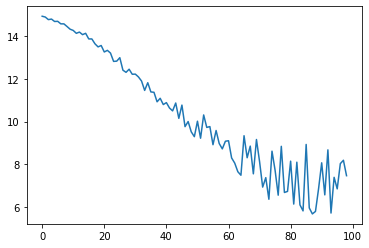

In [21]:
adams_pgn = open("anand.pgn")

def main_adams():
    game_moves, side = extractdata(adams_pgn)
    PW, PB = categorize_moves(game_moves, side, 'Anand, V.')
    X, y = one_hot_matrix(PW, PB)
    image_shape = (8,8,13)
    d_model = define_discriminator()
    g_model = define_generator()
    gan_model = define_gan(g_model, d_model, image_shape)
    d_loss1_list, d_loss2_list, g_loss_list, steps, gan_model = train(d_model, g_model, gan_model, [X, y])
    gan_model.save('test.h5')
    mpl.plot(steps, g_loss_list)
    
    mpl.show()
main_adams()

In [24]:
import h5py
filename = "/Users/zoepratt/Documents/GitHub/Top-Chess-Players/code/test.h5"
#data = open(filename)

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])

Keys: <KeysViewHDF5 ['model_weights', 'optimizer_weights']>


124
124
>1, d1[0.347] d2[0.347] g[14.899]
>2, d1[0.346] d2[0.347] g[14.827]
>3, d1[0.346] d2[0.347] g[14.804]
>4, d1[0.346] d2[0.347] g[14.714]
>5, d1[0.346] d2[0.347] g[14.738]
>6, d1[0.346] d2[0.347] g[14.589]
>7, d1[0.346] d2[0.347] g[14.517]
>8, d1[0.346] d2[0.347] g[14.498]
>9, d1[0.346] d2[0.347] g[14.288]
>10, d1[0.346] d2[0.347] g[14.214]
>11, d1[0.346] d2[0.347] g[14.438]
>12, d1[0.346] d2[0.347] g[14.407]
>13, d1[0.346] d2[0.347] g[14.202]
>14, d1[0.346] d2[0.347] g[14.215]
>15, d1[0.346] d2[0.347] g[14.088]
>16, d1[0.346] d2[0.347] g[14.143]
>17, d1[0.346] d2[0.347] g[13.701]
>18, d1[0.346] d2[0.347] g[13.727]
>19, d1[0.346] d2[0.347] g[13.682]
>20, d1[0.346] d2[0.347] g[13.524]
>21, d1[0.346] d2[0.347] g[13.694]
>22, d1[0.346] d2[0.347] g[13.424]
>23, d1[0.346] d2[0.347] g[13.318]
>24, d1[0.346] d2[0.347] g[13.150]
>25, d1[0.346] d2[0.347] g[13.104]
>26, d1[0.347] d2[0.347] g[12.697]
>27, d1[0.347] d2[0.347] g[12.673]
>28, d1[0.347] d2[0.347] g[13.156]
>29, d1[0.347] d2[0.3

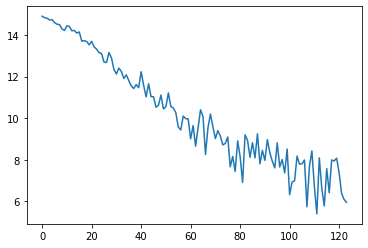

In [33]:
game_moves, side = extractdata(adams_pgn)
PW, PB = categorize_moves(game_moves, side, 'Anand, V.')
X, y = one_hot_matrix(PW, PB)
image_shape = (8,8,13)
d_model = define_discriminator()
g_model = define_generator()
gan_model = define_gan(g_model, d_model, image_shape)
d_loss1_list, d_loss2_list, g_loss_list, steps, gan_model = train(d_model, g_model, gan_model, [X, y])
gan_model.save('test.h5')
mpl.plot(steps, g_loss_list)
mpl.show()
    

In [27]:
gan_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 8, 8, 13)]   0           []                               
                                                                                                  
 model_6 (Functional)           (None, 8, 8, 13)     2532493     ['input_12[0][0]']               
                                                                                                  
 model_5 (Functional)           (None, 1, 1, 1)      6988737     ['input_12[0][0]',               
                                                                  'model_6[0][0]']                
                                                                                                  
Total params: 9,521,230
Trainable params: 2,531,853
Non-trainable params: 6,989,377
________

In [36]:
anand_model = keras.models.load_model('test.h5')

In [37]:
anand_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 8, 8, 13)]   0           []                               
                                                                                                  
 model_6 (Functional)           (None, 8, 8, 13)     2532493     ['input_12[0][0]']               
                                                                                                  
 model_5 (Functional)           (None, 1, 1, 1)      6988737     ['input_12[0][0]',               
                                                                  'model_6[0][0]']                
                                                                                                  
Total params: 9,521,230
Trainable params: 2,531,853
Non-trainable params: 6,989,377
________